In [16]:
import torch.nn as nn
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate, HierarchicalDataset, Pipeline

DH = DataHolder(**paths)
#HD = HierarchicalDataset(DH)
#dl = HD.dataloader()
#DH.openface_tensor[1] = DH.openface_tensor[1]/5
#DH.openface_tensor[2] = DH.openface_tensor[2]/5

In [17]:
output = DH.make_train_test_datasets(test_size = .15, val_size = .17)
class_weights = output['class_weights']
openface_1  = output['datasets']['openface_1']
openface_2  = output['datasets']['openface_2']
#opensmile_1 = output['datasets']['opensmile_1']
#opensmile_2 = output['datasets']['opensmile_2']

Training on cpu
loss epoch 16: 2.038261
loss epoch 32: 1.952638
loss epoch 48: 1.937045
loss epoch 64: 1.946868
loss epoch 80: 1.949157


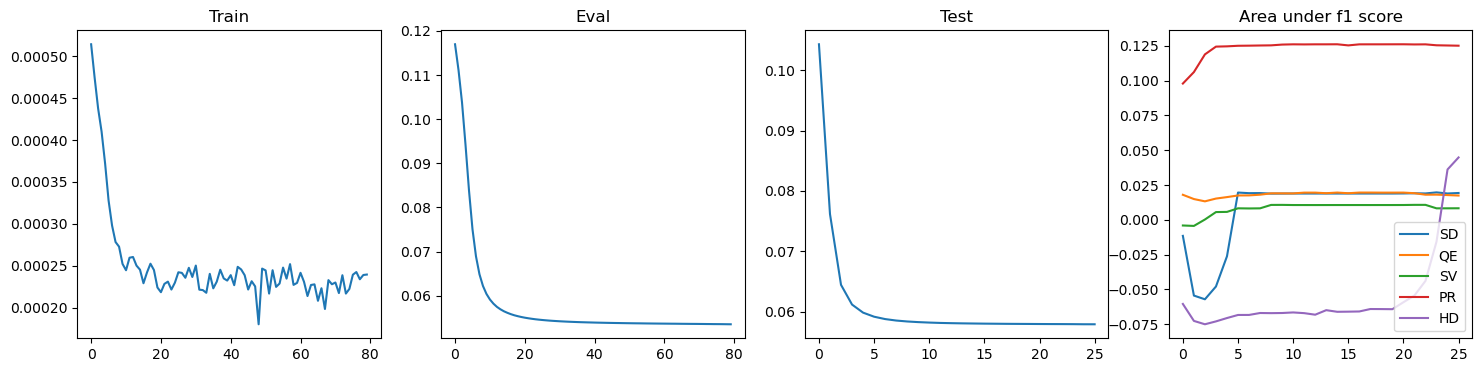

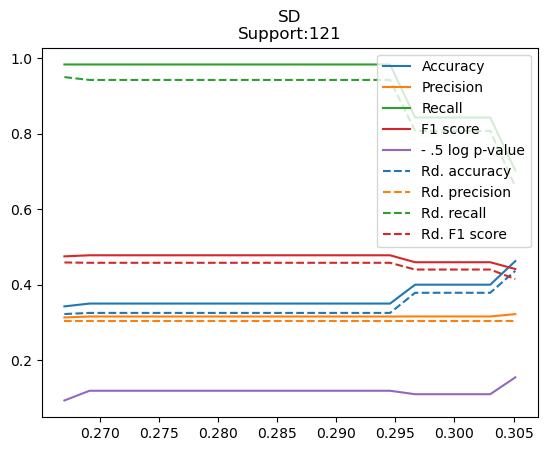

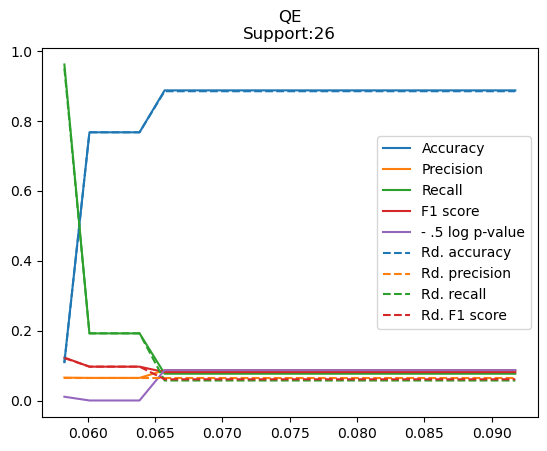

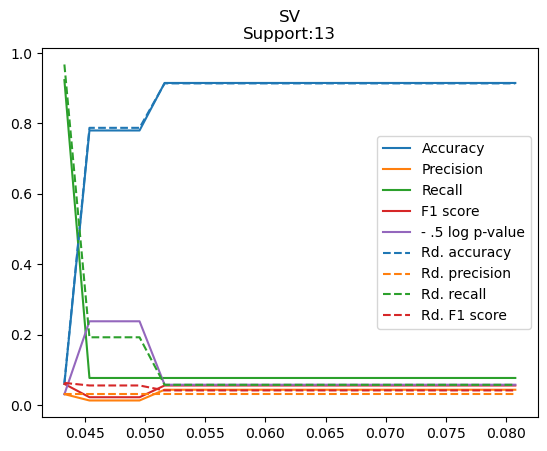

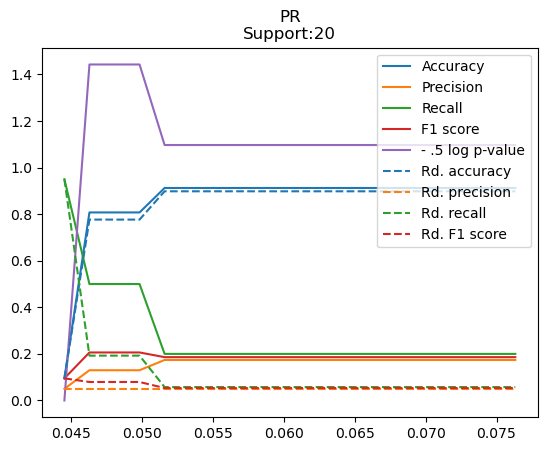

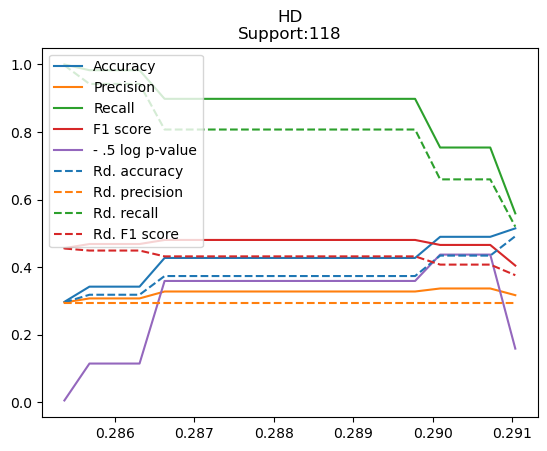

[0.019949295101006282,
 0.016335275991883176,
 0.0056506578947368375,
 0.12467286653459347,
 0.041936962639535925]

In [27]:
model_args = {
    'input_dim':17,
    'hidden_dim':8,
    'layer_dim':8,
    'output_dim':5,
    'dropout_prob':.1
}

mseloss = nn.MSELoss()
def my_loss(pred, true):
    return mseloss(pred, 3*true)

args={
    'model': GRUModel(**model_args),
    'features_1':openface_1,
    'features_2':openface_2,
    #'features_1':opensmile_1,
    #'features_2':opensmile_2,
    #'criterion':nn.L1Loss()#weight=class_weights)
    #'criterion':nn.KLDivLoss(reduction='batchmean')
    #'criterion':my_loss
    'criterion':nn.MSELoss()
}
pipe = Pipeline(**args)
pipe.train(epoch=50,lr=1e-3, early_stop=False)
pipe.plot_losses()
pipe.eval_model(plot=True)